In [43]:
facedetector = load_model('melathy.h5')

In [47]:
from PIL import Image

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((120, 120))
    image = image.convert("RGB") 
    image = np.array(image)  
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    
    return image

In [55]:
def extractROI(img, coords):
    image = img

    if image is None:
        print("Failed to load the image:", img)
        return None

    x = tf.cast(coords[0], tf.float32) * tf.cast(tf.shape(image)[1], tf.float32)
    y = tf.cast(coords[1], tf.float32) * tf.cast(tf.shape(image)[0], tf.float32)
    w = tf.cast(coords[2], tf.float32) * tf.cast(tf.shape(image)[1], tf.float32)
    h = tf.cast(coords[3], tf.float32) * tf.cast(tf.shape(image)[0], tf.float32)

    # Coordinate ROI forehead
    roi_x_forehead = tf.cast(x + w * 0.1, tf.int32)
    roi_y_forehead = tf.cast(y + h * 0.07, tf.int32)
    roi_w_forehead = tf.cast(w * 0.5, tf.int32)
    roi_h_forehead = tf.cast(h * 0.08, tf.int32)

    # Forehead
    roi_forehead = image[roi_y_forehead:roi_y_forehead + roi_h_forehead, roi_x_forehead:roi_x_forehead + roi_w_forehead]
    # roi_forehead = tf.image.resize(roi_forehead, [32, 32])

    # Coordinate ROI left cheek
    roi_x_left_cheek = tf.cast(x + w * 0.04, tf.int32)
    roi_y_left_cheek = tf.cast(y + h * 0.29, tf.int32)
    roi_w_left_cheek = tf.cast(w * 0.2, tf.int32)
    roi_h_left_cheek = tf.cast(h * 0.13, tf.int32)

    # Left Cheek
    roi_left_cheek = image[roi_y_left_cheek:roi_y_left_cheek + roi_h_left_cheek, roi_x_left_cheek:roi_x_left_cheek + roi_w_left_cheek]
    # roi_left_cheek = tf.image.resize(roi_left_cheek, [32, 32])

    # Coordinate ROI right cheek
    roi_x_right_cheek = tf.cast(x + w * 0.47, tf.int32)
    roi_y_right_cheek = tf.cast(y + h * 0.3, tf.int32)
    roi_w_right_cheek = tf.cast(w * 0.2, tf.int32)
    roi_h_right_cheek = tf.cast(h * 0.13, tf.int32)

    # Right Cheek
    roi_right_cheek = image[roi_y_right_cheek:roi_y_right_cheek + roi_h_right_cheek, roi_x_right_cheek:roi_x_right_cheek + roi_w_right_cheek]
    # roi_right_cheek = tf.image.resize(roi_right_cheek, [32, 32])
    
    roi_red_forehead = roi_forehead[:, :, 0]
    roi_red_lcheek = roi_left_cheek[:, :, 0]
    roi_red_rcheek = roi_right_cheek[:, :, 0]
    
    red_data = np.concatenate((roi_red_forehead.flatten(), roi_red_lcheek.flatten(), roi_red_rcheek.flatten()))
    
    return red_data

In [71]:
image_path = 'aug_data/train/images/1685344291041.1.jpg'
input_image = preprocess_image(image_path)

In [72]:
yhat = facedetector.predict(input_image)

1/1 [==============================] - 0s 87ms/step


In [88]:
yhat[1]

array([[0.13171577, 0.00176438, 0.9850437 , 0.9941602 ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


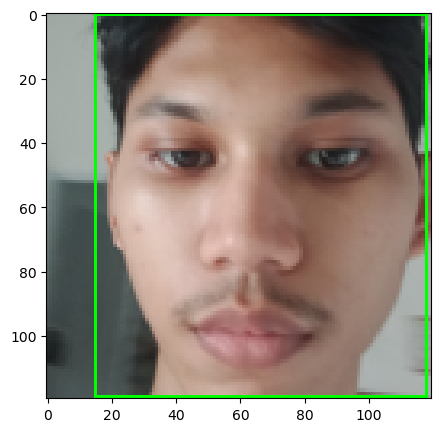

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

sample_image = np.squeeze(input_image)  # Remove the batch dimension if present
sample_coords = yhat[1][0] # Access the first element of the output array

x1, y1, x2, y2 = np.multiply(sample_coords[0:4], [120, 120, 120, 120]).astype(int)

cv2.rectangle(sample_image, (x1, y1), (x2, y2), (0, 255, 0), 1)

ax.imshow(sample_image)
plt.show()


In [93]:
red_data = extractROI(sample_image,yhat[1][0])

In [121]:
normalized_signal = (red_data - np.min(red_data)) / (np.max(red_data) - np.min(red_data))
detrended_signal = signal.detrend(normalized_signal)

# Heart Rate

In [135]:
# Filtering by low-pass Butterworth filter
fs = 20  
cutoff_freq = 5  
order = 4
nyquist_freq = 0.5 * fs
normalized_cutoff_freq = cutoff_freq / nyquist_freq
b, a = signal.butter(order, normalized_cutoff_freq, btype='low')
filtered_signal = signal.filtfilt(b, a, detrended_signal)

In [136]:
peaks, _ = signal.find_peaks(filtered_signal, distance=int(fs/2))

In [137]:
heart_rate = round(len(peaks) / (len(filtered_signal) / fs) * 60) # detakan per menit (BPM)

In [138]:
heart_rate

69

# Respiration Rate

In [139]:
cutoff_freq_rr = 0.2
normalized_cutoff_freq_rr = cutoff_freq_rr / nyquist_freq
b_rr, a_rr = signal.butter(order, normalized_cutoff_freq_rr, btype='low')
filtered_signal_rr = signal.filtfilt(b_rr, a_rr, detrended_signal)
respiration_peaks, _ = signal.find_peaks(filtered_signal_rr, distance=int(fs/2))
time_intervals = np.diff(respiration_peaks) / fs  
mean_interval = np.mean(time_intervals)
respiration_rate = round(60 / mean_interval)

In [140]:
respiration_rate

6